# Variance Thresholding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
cat_df = pd.get_dummies(df[cat_cols])
df = pd.concat((df.drop(cat_cols, axis=1), cat_df), axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,...,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,0,1,1,0,...,0,1,0,0,1,0,1,1,0,0
1,12250000,8960,4,4,4,3,0,1,1,0,...,0,1,0,0,1,1,0,1,0,0
2,12250000,9960,3,2,2,2,0,1,1,0,...,1,1,0,1,0,0,1,0,1,0
3,12215000,7500,4,2,2,3,0,1,1,0,...,1,1,0,0,1,0,1,1,0,0
4,11410000,7420,4,1,2,2,0,1,0,1,...,1,1,0,0,1,1,0,1,0,0


## Fitting a Standard Model - All Features

In [4]:
X = df.drop(['price'], axis=1)
y = df['price']

lr = LinearRegression().fit(X, y)
y_pred = lr.predict(X)
print('Explained Variance: ', explained_variance_score(y, y_pred))
print('MAE: ', mean_absolute_error(y, y_pred))

Explained Variance:  0.6818018485540143
MAE:  775054.3287400284


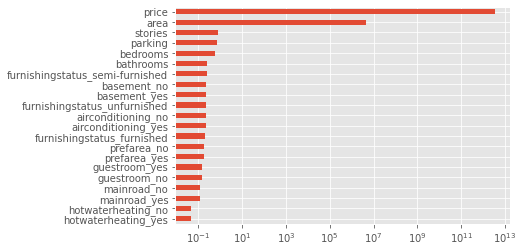

In [5]:
ax = df.var(axis=0).sort_values().plot(kind='barh')
ax.set_xscale('log')

## Drop some low variance features

In [6]:
X_high_var = X.drop(['hotwaterheating_yes', 'hotwaterheating_no'], axis=1)
lr = LinearRegression().fit(X_high_var, y)
y_pred = lr.predict(X_high_var)

print('Explained Variance: ', explained_variance_score(y, y_pred))
print('MAE: ', mean_absolute_error(y, y_pred))

Explained Variance:  0.6729957155057791
MAE:  781399.8475517975


## Can we continue dropping features?

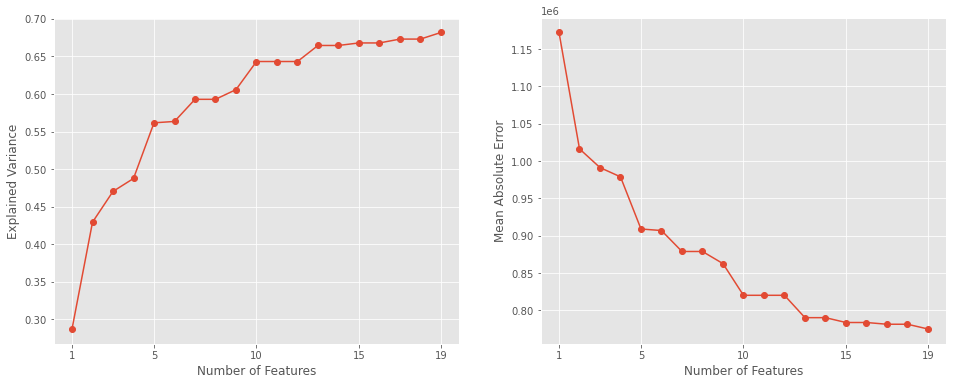

In [7]:
cols = X.var().sort_values().index
n_features_kept = []
var_scores = []
mae_scores = []

model = LinearRegression()

for i in range(1, len(cols)):
    x_high_var = X.drop(cols[:i], axis=1)
    n_features_kept.append(x_high_var.shape[1])
    model.fit(x_high_var, y)
    y_pred = model.predict(x_high_var)
    var_scores.append(explained_variance_score(y, y_pred))
    mae_scores.append(mean_absolute_error(y, y_pred))
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(n_features_kept, var_scores, 'o-')
ax[0].set_xticks([1, 5, 10, 15, 19])
ax[0].set_xlabel('Number of Features')
ax[0].set_ylabel('Explained Variance')
ax[1].plot(n_features_kept, mae_scores, 'o-')
ax[1].set_xticks([1, 5, 10, 15, 19])
ax[1].set_xlabel('Number of Features')
_ = ax[1].set_ylabel('Mean Absolute Error')

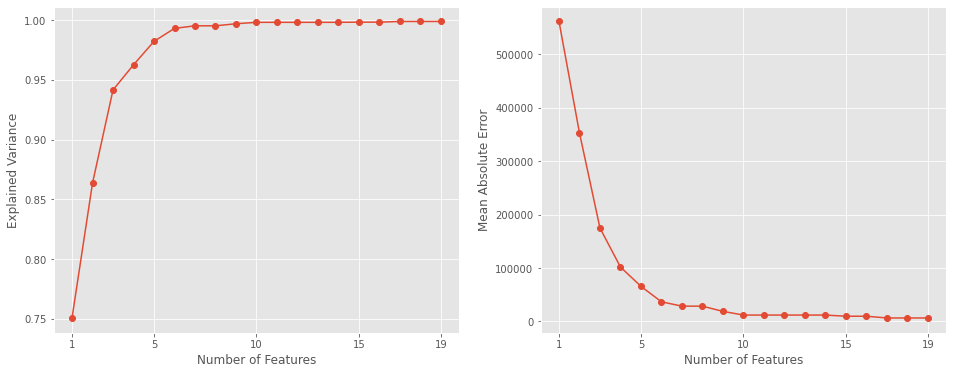

In [8]:
cols = X.var().sort_values().index
n_features_kept = []
var_scores = []
mae_scores = []

model = DecisionTreeRegressor()

for i in range(1, len(cols)):
    x_high_var = X.drop(cols[:i], axis=1)
    n_features_kept.append(x_high_var.shape[1])
    model.fit(x_high_var, y)
    y_pred = model.predict(x_high_var)
    var_scores.append(explained_variance_score(y, y_pred))
    mae_scores.append(mean_absolute_error(y, y_pred))
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(n_features_kept, var_scores, 'o-')
ax[0].set_xticks([1, 5, 10, 15, 19])

ax[0].set_xlabel('Number of Features')
ax[0].set_ylabel('Explained Variance')
ax[1].plot(n_features_kept, mae_scores, 'o-')
ax[1].set_xticks([1, 5, 10, 15, 19])
ax[1].set_xlabel('Number of Features')
_ = ax[1].set_ylabel('Mean Absolute Error')

### Automating Variance Thresholding with [`sklearn.feature_selection.VarianceThresold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)

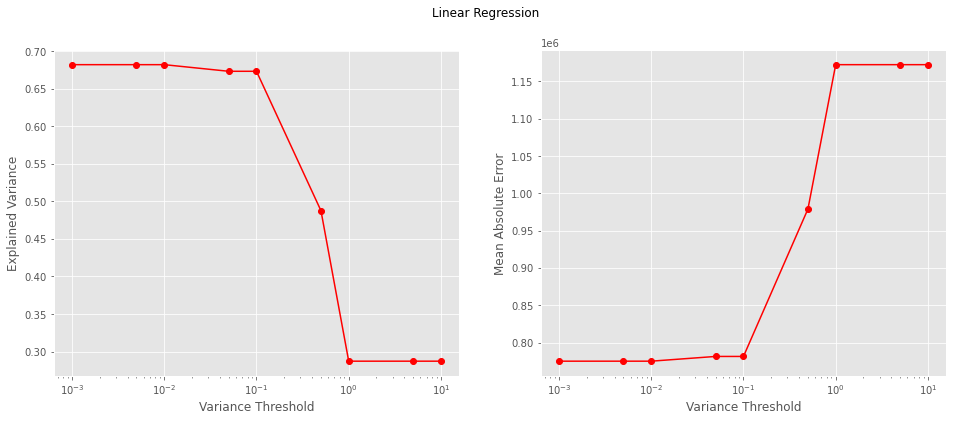

In [9]:
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
var_scores = []
mae_scores = []

model = LinearRegression()


for t in thresholds:
    vt = VarianceThreshold(t)
    x_high_var = vt.fit_transform(X)
    model.fit(x_high_var, y)
    y_pred = model.predict(x_high_var)
    var_scores.append(explained_variance_score(y, y_pred))
    mae_scores.append(mean_absolute_error(y, y_pred))

    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(thresholds, var_scores, 'ro-', label='Score')
ax[0].set_xscale('log')
ax[0].set_xlabel('Variance Threshold')
ax[0].set_ylabel('Explained Variance')
ax[1].plot(thresholds, mae_scores, 'ro-', label='Score')
ax[1].set_xscale('log')
ax[1].set_xlabel('Variance Threshold')
ax[1].set_ylabel('Mean Absolute Error')
_ = plt.suptitle('Linear Regression')

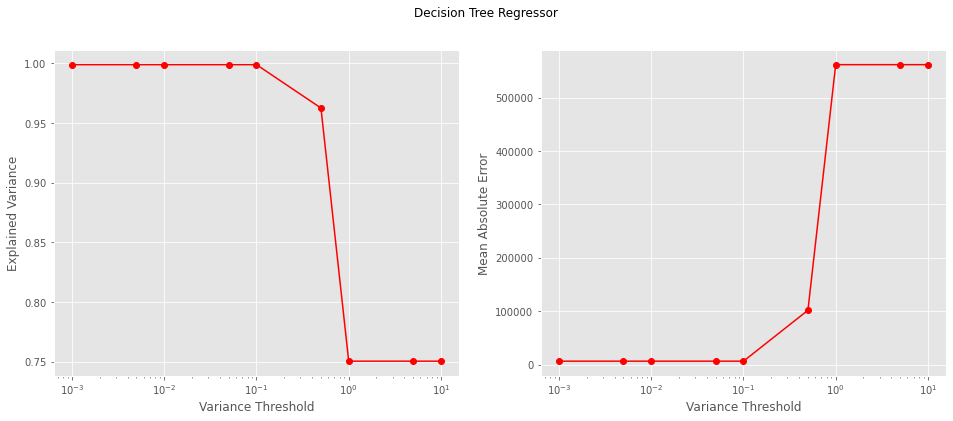

In [10]:
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
var_scores = []
mae_scores = []

model = DecisionTreeRegressor()


for t in thresholds:
    vt = VarianceThreshold(t)
    x_high_var = vt.fit_transform(X)
    model.fit(x_high_var, y)
    y_pred = model.predict(x_high_var)
    var_scores.append(explained_variance_score(y, y_pred))
    mae_scores.append(mean_absolute_error(y, y_pred))

    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(thresholds, var_scores, 'ro-', label='Score')
ax[0].set_xscale('log')
ax[0].set_xlabel('Variance Threshold')
ax[0].set_ylabel('Explained Variance')
ax[1].plot(thresholds, mae_scores, 'ro-', label='Score')
ax[1].set_xscale('log')
ax[1].set_xlabel('Variance Threshold')
ax[1].set_ylabel('Mean Absolute Error')
_ = plt.suptitle('Decision Tree Regressor')